In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


In [46]:
train_df = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/train.csv")
test_df = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/test.csv")

In [47]:
train_df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [49]:
train_df.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [50]:
binary_cols = ['ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin','ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin']
categorical_cols = ['ps_ind_02_cat','ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat']
num_cols = ['ps_ind_01','ps_ind_03','ps_ind_14', 'ps_ind_15','ps_reg_01',
       'ps_reg_02', 'ps_reg_03','ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',]

In [51]:
train_df = train_df.replace(-1, np.nan)

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   594996 non-null  float64
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595129 non-null  float64
 6   ps_ind_05_cat   589403 non-null  float64
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

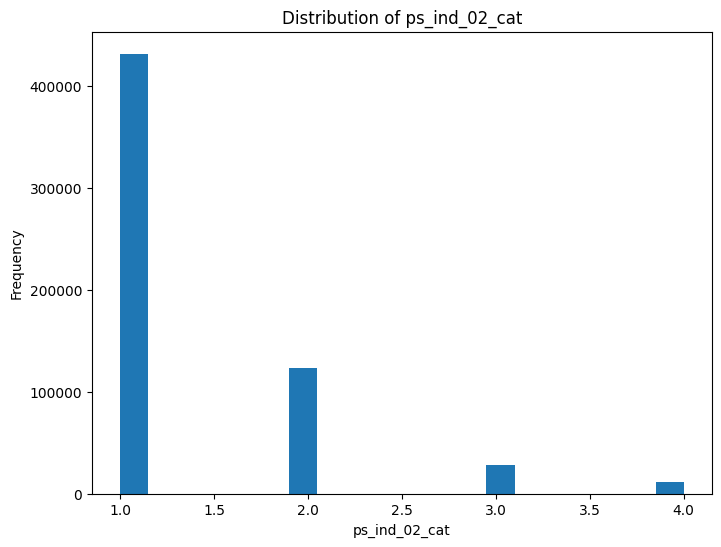

ps_ind_02_cat
1.0    431859
2.0    123573
3.0     28186
4.0     11378
Name: count, dtype: int64


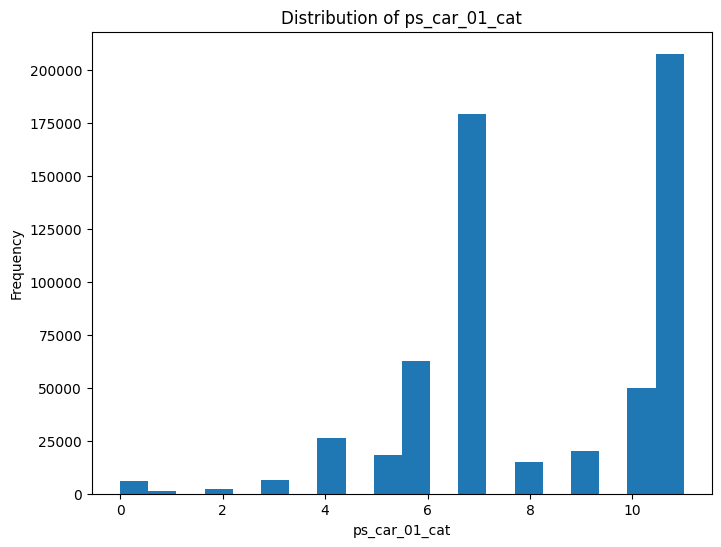

ps_car_01_cat
11.0    207573
7.0     179247
6.0      62393
10.0     50087
4.0      26174
9.0      20323
5.0      18142
8.0      15093
3.0       6658
0.0       5904
2.0       2144
1.0       1367
Name: count, dtype: int64


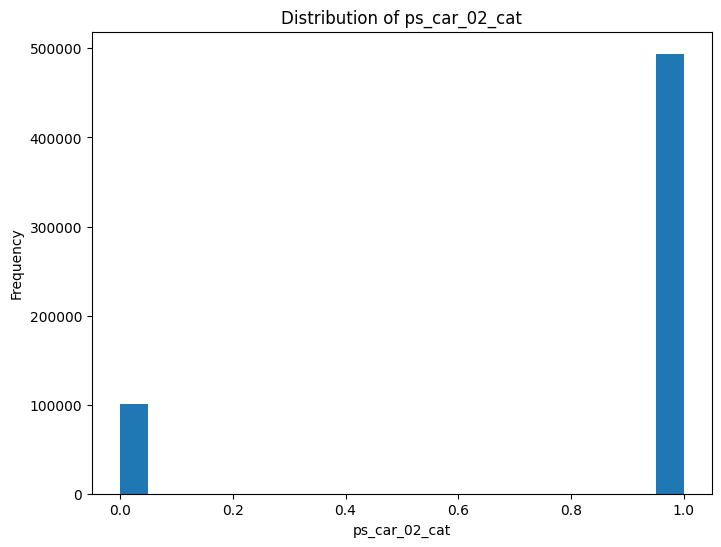

ps_car_02_cat
1.0    493990
0.0    101217
Name: count, dtype: int64


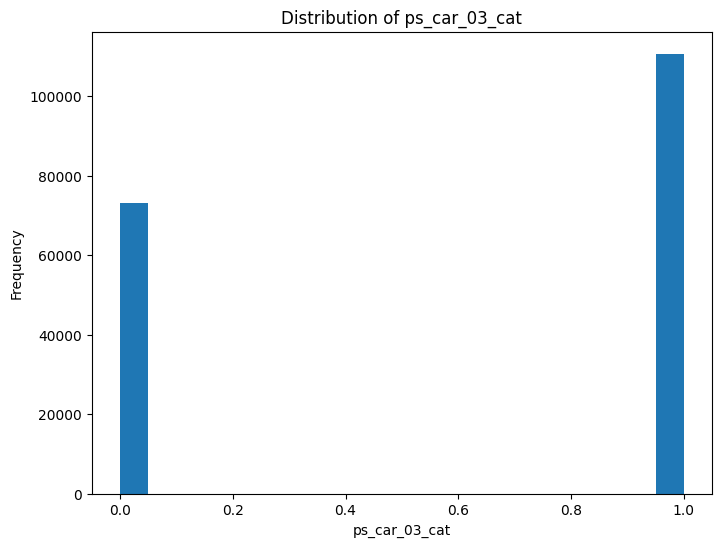

ps_car_03_cat
1.0    110709
0.0     73272
Name: count, dtype: int64


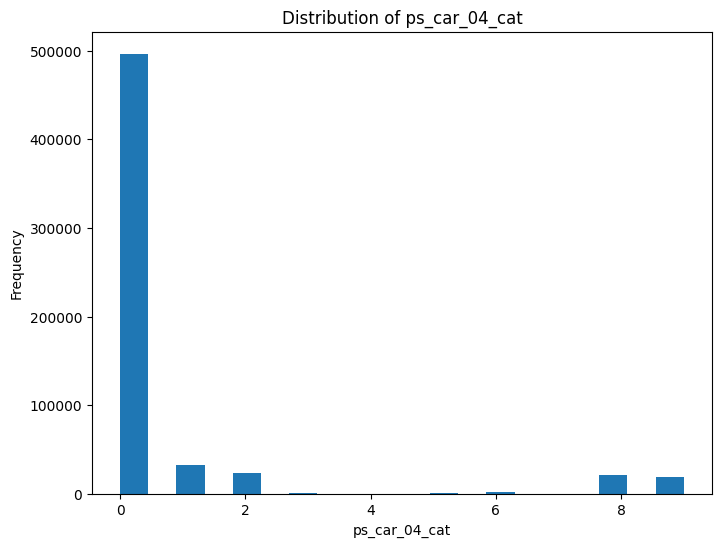

ps_car_04_cat
0    496581
1     32115
2     23770
8     20598
9     19034
6      1560
3       640
5       545
4       230
7       139
Name: count, dtype: int64


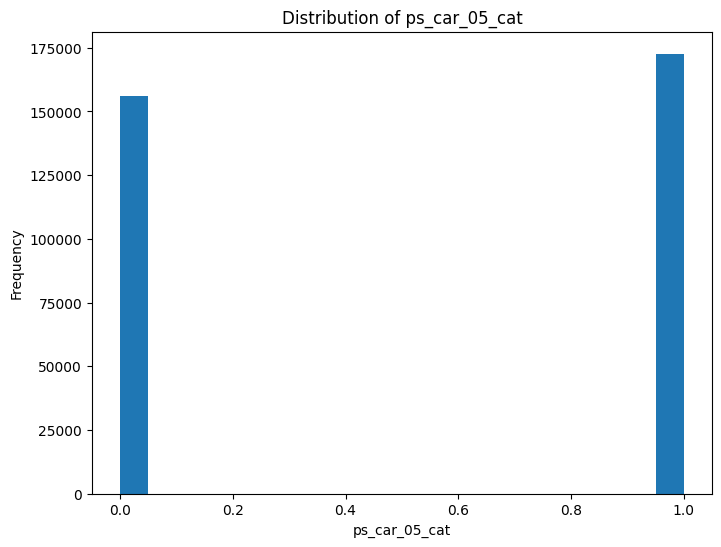

ps_car_05_cat
1.0    172667
0.0    155994
Name: count, dtype: int64


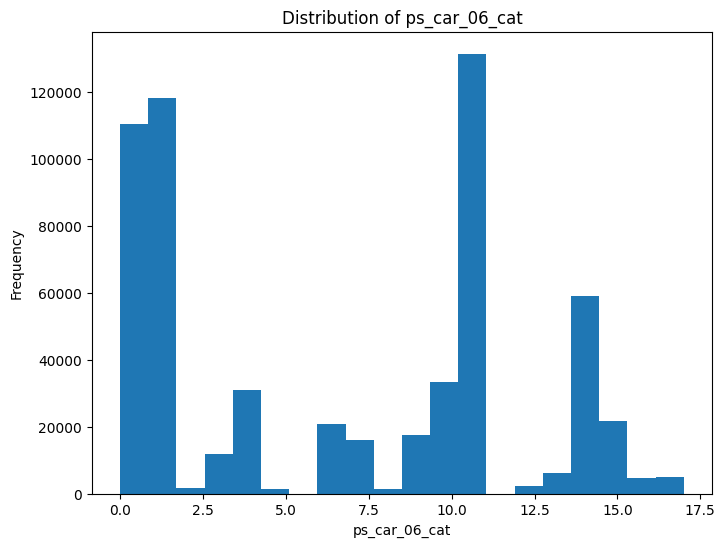

ps_car_06_cat
11    131527
1     118386
0     110420
14     59253
10     33466
4      31136
15     21732
6      20951
9      17617
7      16158
3      11997
13      6246
17      4935
16      4582
12      2386
2       1607
8       1412
5       1401
Name: count, dtype: int64


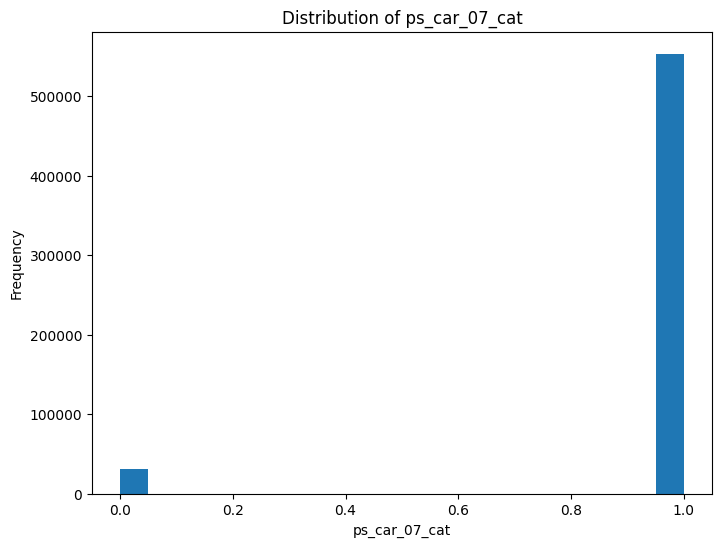

ps_car_07_cat
1.0    553148
0.0     30575
Name: count, dtype: int64


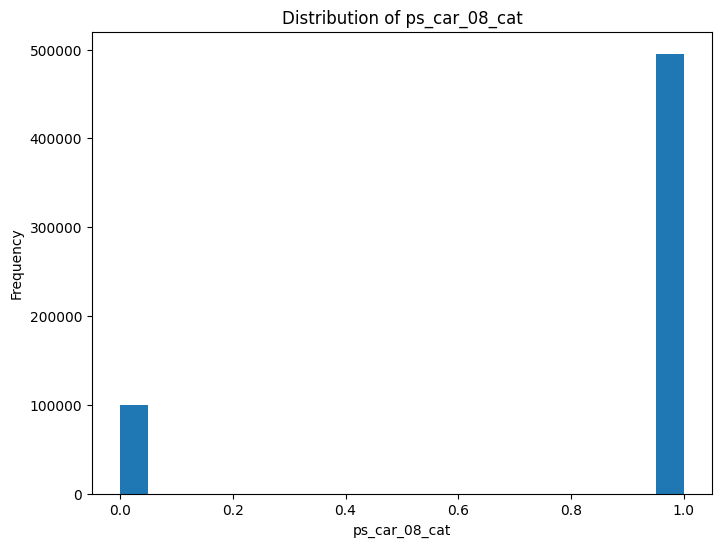

ps_car_08_cat
1    495264
0     99948
Name: count, dtype: int64


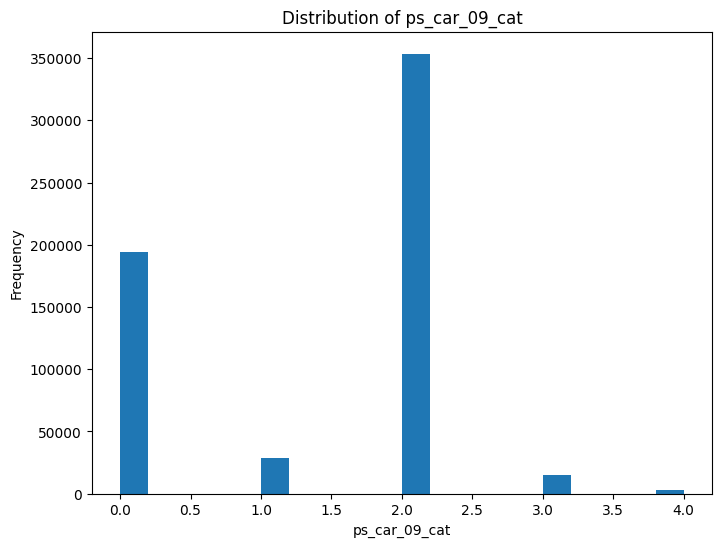

ps_car_09_cat
2.0    353482
0.0    194518
1.0     29080
3.0     14756
4.0      2807
Name: count, dtype: int64


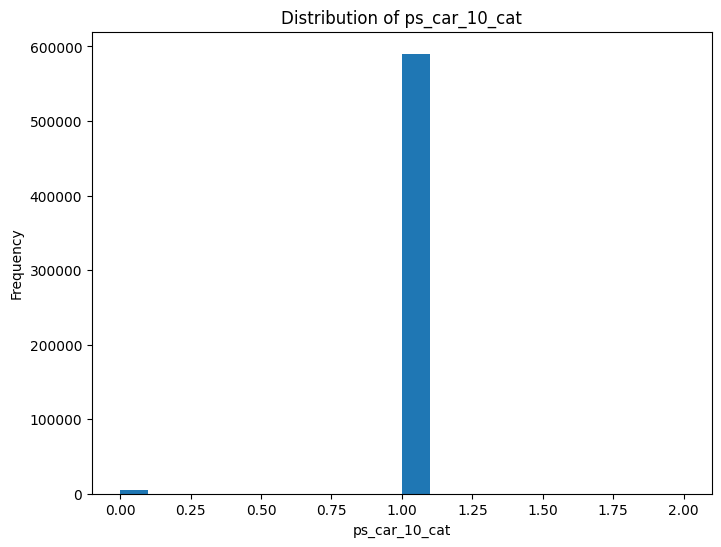

ps_car_10_cat
1    590179
0      4857
2       176
Name: count, dtype: int64


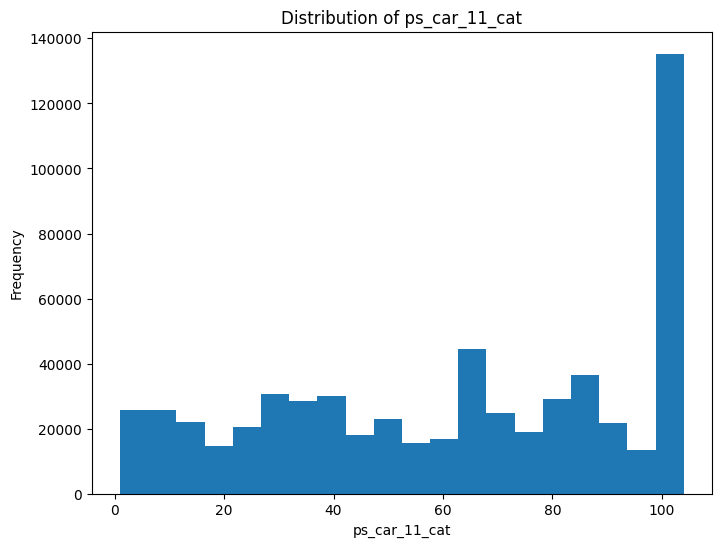

ps_car_11_cat
104    85083
103    24262
64     22278
87     17106
32     12578
       ...  
58      1464
81      1433
56      1272
18      1233
63      1103
Name: count, Length: 104, dtype: int64


In [53]:
for column in categorical_cols:
    plt.figure(figsize=(8, 6))  
    train_df[column].hist(bins=20)    
    plt.title(f'Distribution of {column}')  
    plt.xlabel(column)  
    plt.ylabel('Frequency')  
    plt.grid(False)  
    plt.show()
    print(train_df[column].value_counts())

In [54]:
not_cat_but_binary = []
for column in categorical_cols:
    if train_df[column].nunique() == 2:
        not_cat_but_binary.append(column)
        
not_cat_but_binary
    

['ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_08_cat']

car_03 and car_05 will stay as categorical, because they have a high amount of nan values and the number of 0s and 1s are very close

In [55]:
binary_cols = ['ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin','ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_car_02_cat','ps_car_07_cat','ps_car_08_cat']
categorical_cols = ['ps_ind_02_cat','ps_car_01_cat','ps_car_03_cat', 'ps_car_04_cat','ps_car_05_cat', 'ps_car_06_cat','ps_car_09_cat', 'ps_car_10_cat','ps_car_11_cat']

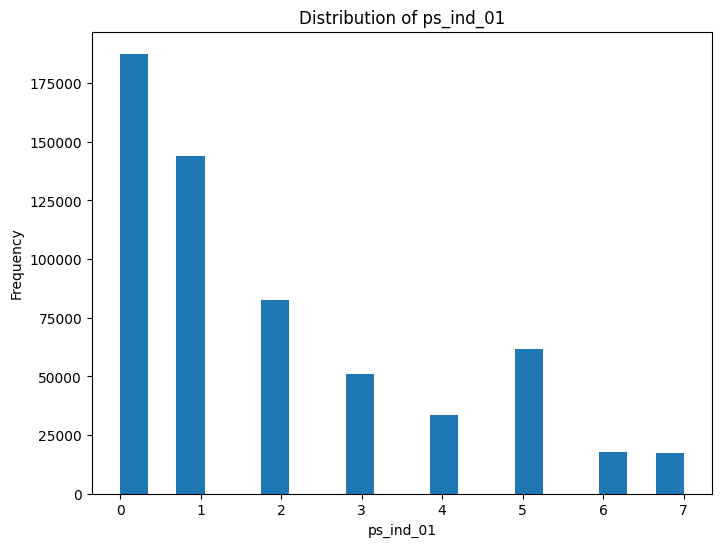

ps_ind_01
0    187594
1    143984
2     82468
5     61464
3     51193
4     33524
6     17682
7     17303
Name: count, dtype: int64


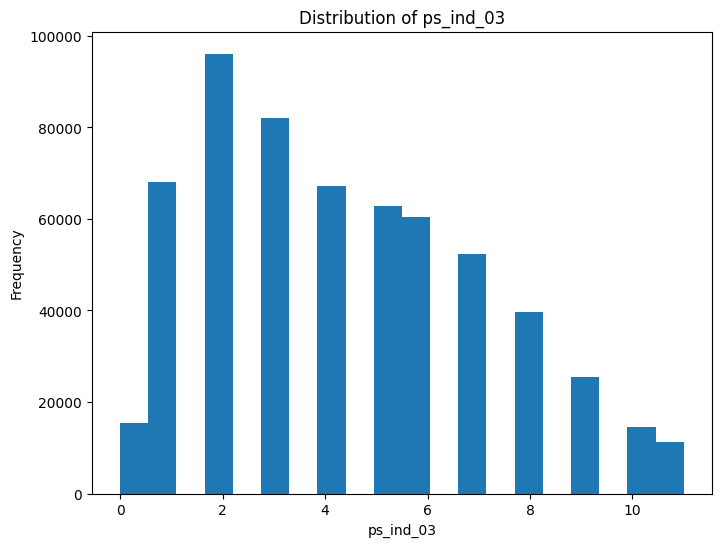

ps_ind_03
2     96110
3     81973
1     67994
4     67213
5     62803
6     60406
7     52364
8     39667
9     25436
0     15514
10    14484
11    11248
Name: count, dtype: int64


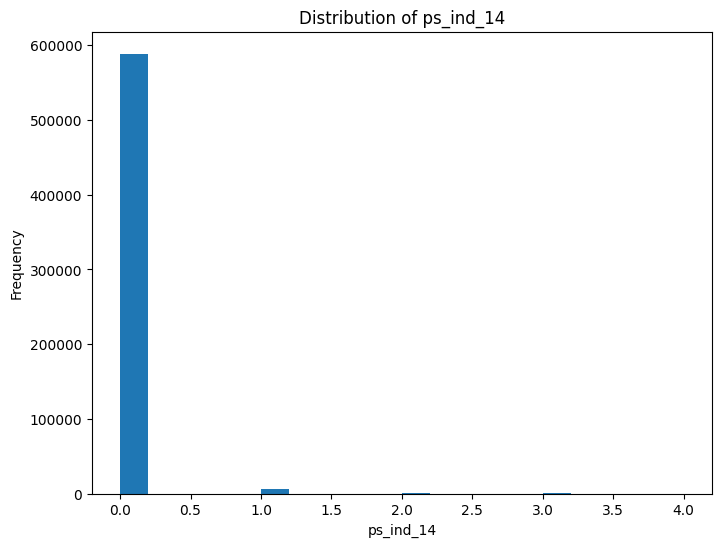

ps_ind_14
0    588832
1      5495
2       744
3       136
4         5
Name: count, dtype: int64


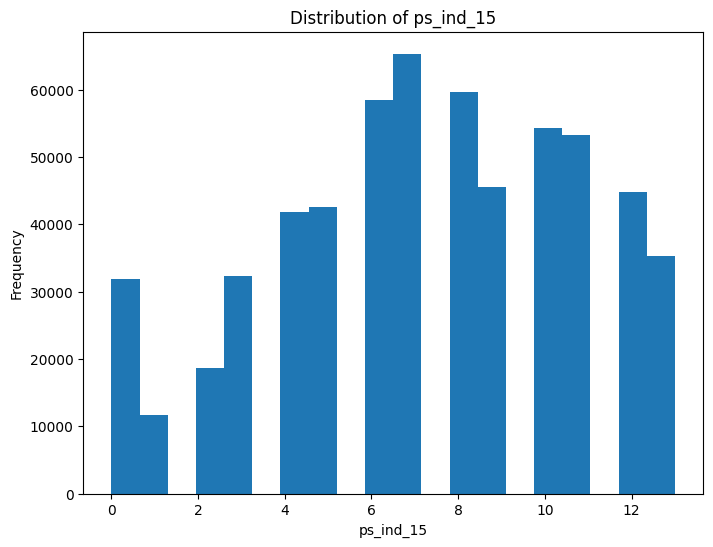

ps_ind_15
7     65336
8     59600
6     58408
10    54341
11    53215
9     45497
12    44851
5     42553
4     41770
13    35256
3     32267
0     31826
2     18675
1     11617
Name: count, dtype: int64


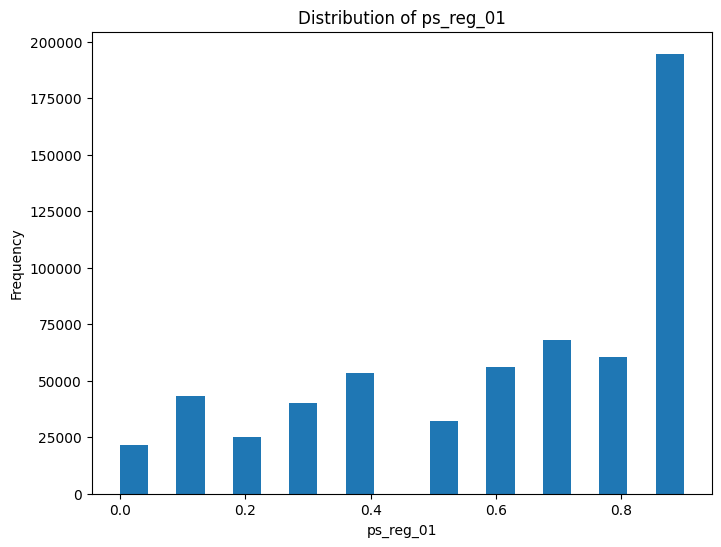

ps_reg_01
0.9    194608
0.7     67897
0.8     60277
0.6     56243
0.4     53569
0.1     43192
0.3     40290
0.5     32341
0.2     25113
0.0     21682
Name: count, dtype: int64


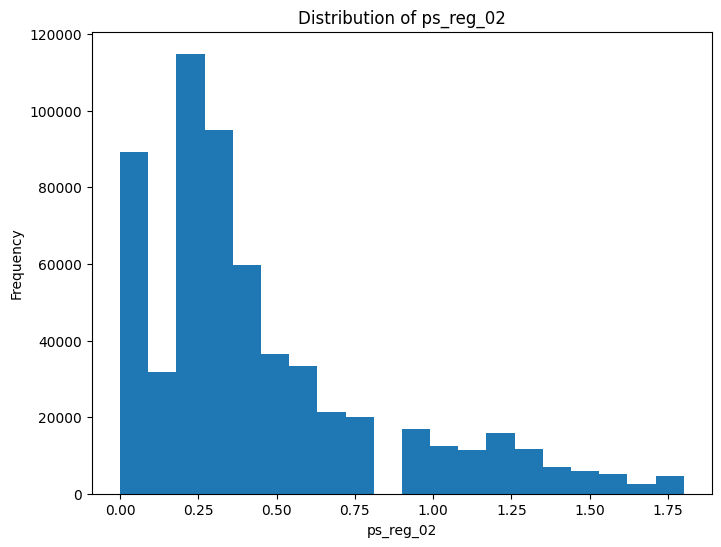

ps_reg_02
0.2    114886
0.3     95033
0.0     89297
0.4     59746
0.5     36528
0.6     33474
0.1     31816
0.7     21210
0.8     19907
0.9     16788
1.2     15843
1.0     12570
1.3     11761
1.1     11321
1.4      6877
1.5      5845
1.6      5095
1.8      4737
1.7      2478
Name: count, dtype: int64


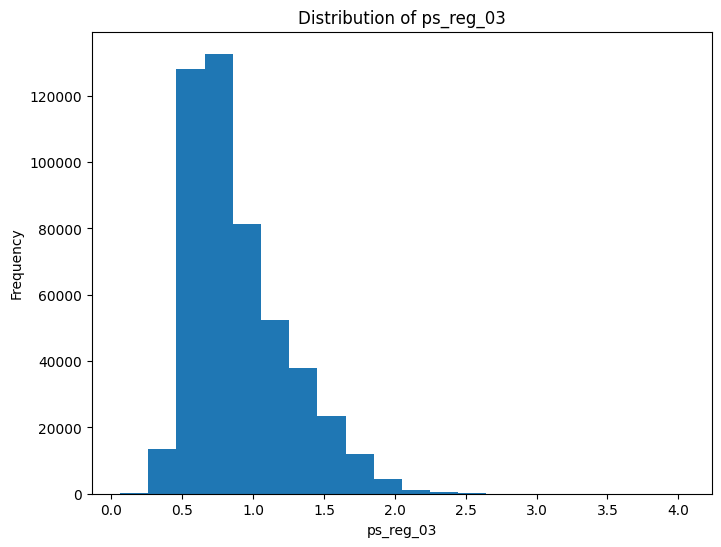

ps_reg_03
0.633936    664
0.602599    637
0.704894    627
0.587899    616
0.680074    598
           ... 
0.215058      1
1.620764      1
1.967073      1
1.877998      1
1.743560      1
Name: count, Length: 5012, dtype: int64


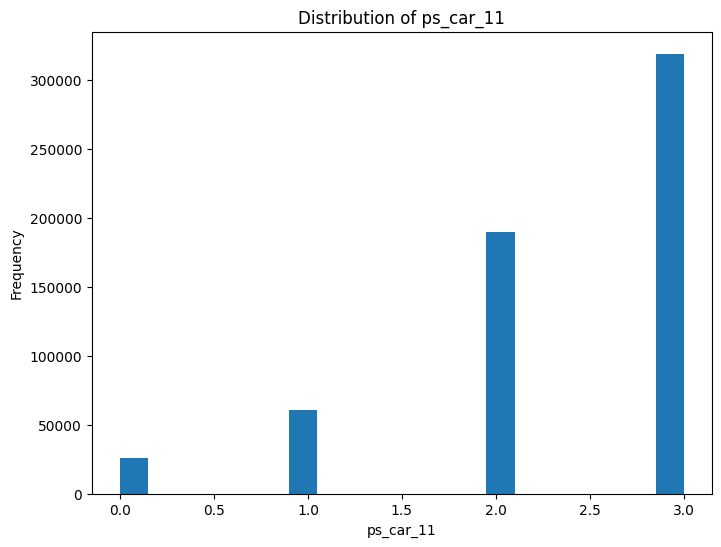

ps_car_11
3.0    318919
2.0    189353
1.0     60952
0.0     25983
Name: count, dtype: int64


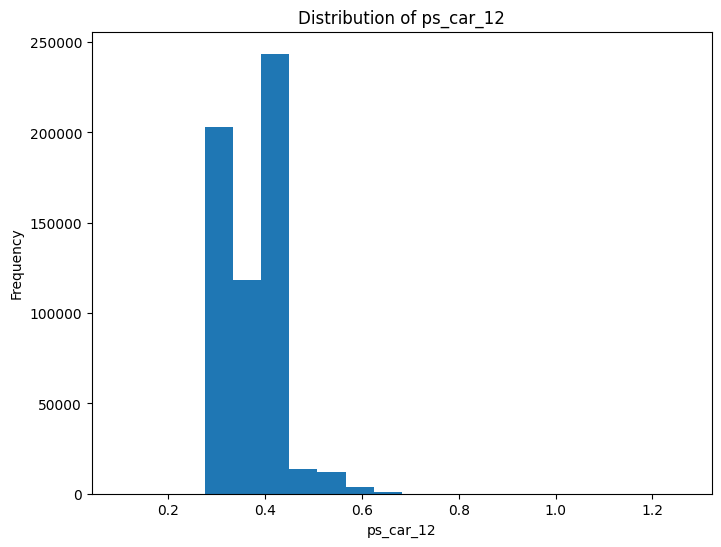

ps_car_12
0.316228    170579
0.400000    111873
0.374166     98598
0.447214     49318
0.424264     49293
             ...  
0.543783         1
0.496387         1
0.647765         1
0.446766         1
0.705195         1
Name: count, Length: 183, dtype: int64


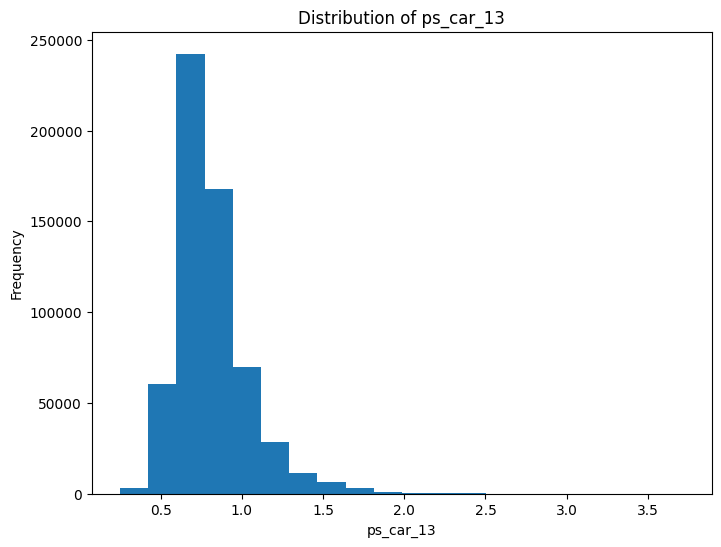

ps_car_13
0.674583    386
0.741689    377
0.692776    363
0.841781    362
0.749228    353
           ... 
1.666391      1
1.190640      1
0.668268      1
0.731630      1
1.561918      1
Name: count, Length: 70482, dtype: int64


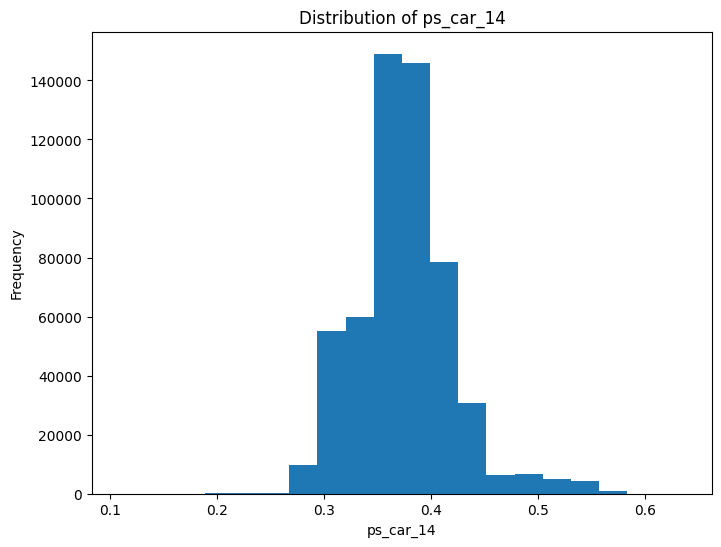

ps_car_14
0.361525    17696
0.358329    15523
0.361939    11885
0.368782    11626
0.397492     9679
            ...  
0.526783        1
0.213073        1
0.603324        1
0.411461        1
0.511371        1
Name: count, Length: 849, dtype: int64


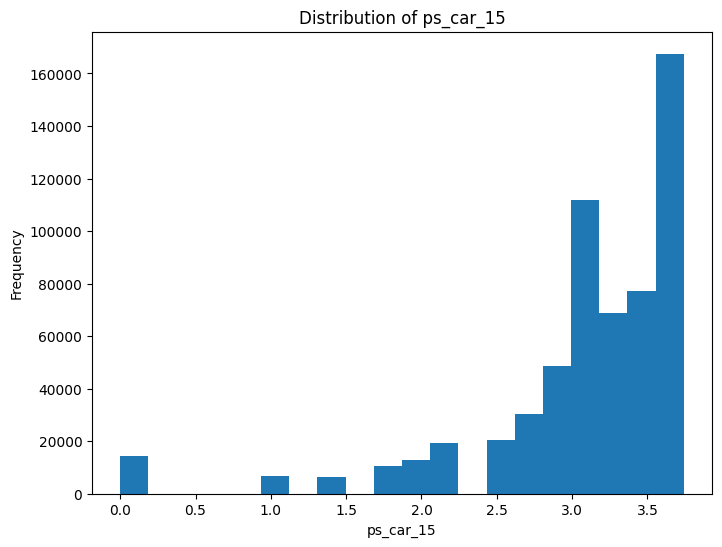

ps_car_15
3.605551    109765
3.464102     77200
3.316625     68737
3.162278     63323
3.741657     57757
2.828427     48680
3.000000     48537
2.645751     30388
2.449490     20445
2.236068     19397
0.000000     14186
2.000000     12830
1.732051     10744
1.000000      6708
1.414214      6515
Name: count, dtype: int64


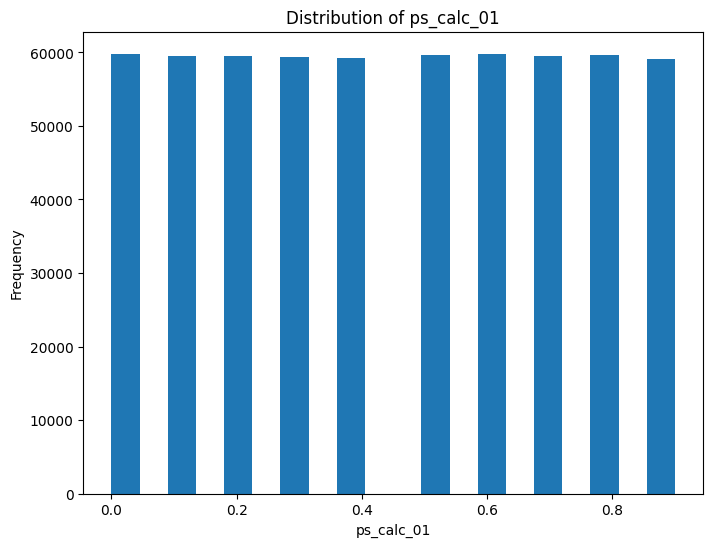

ps_calc_01
0.6    59837
0.0    59780
0.8    59710
0.5    59612
0.7    59545
0.2    59513
0.1    59504
0.3    59377
0.4    59248
0.9    59086
Name: count, dtype: int64


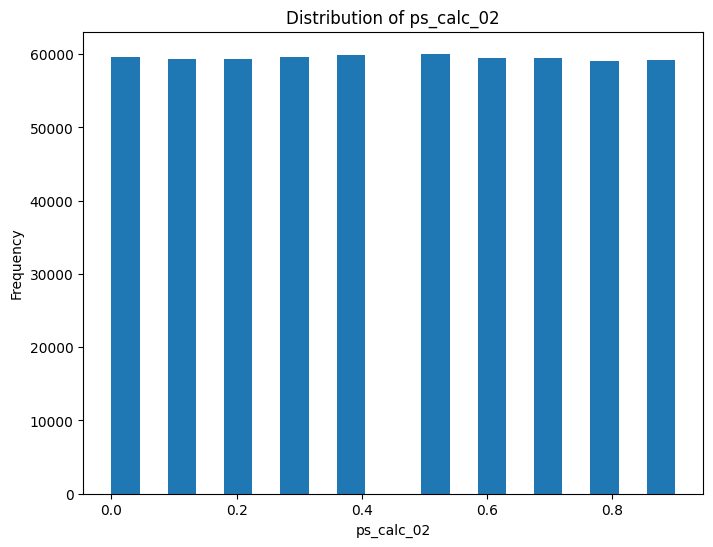

ps_calc_02
0.5    60070
0.4    59823
0.0    59618
0.3    59593
0.7    59502
0.6    59501
0.2    59385
0.1    59383
0.9    59219
0.8    59118
Name: count, dtype: int64


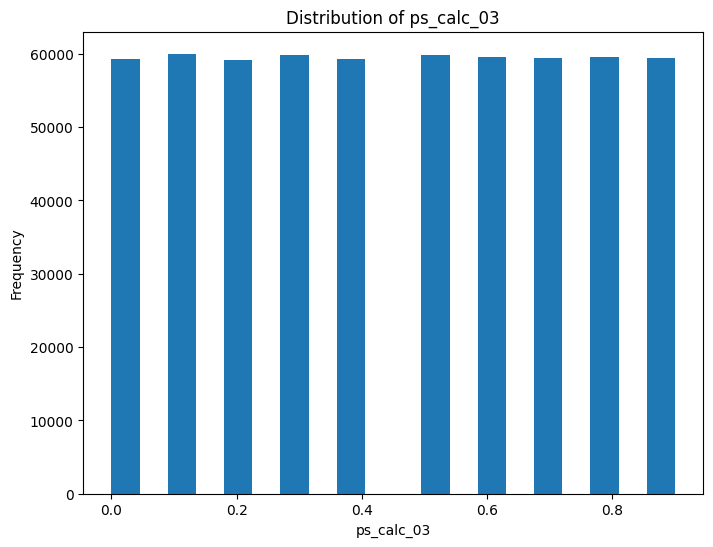

ps_calc_03
0.1    60036
0.5    59832
0.3    59819
0.6    59521
0.8    59509
0.9    59418
0.7    59393
0.0    59318
0.4    59229
0.2    59137
Name: count, dtype: int64


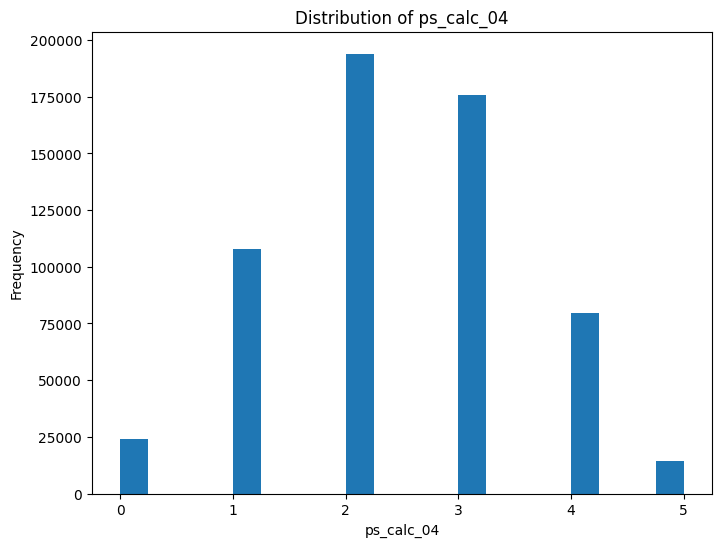

ps_calc_04
2    193977
3    175512
1    108012
4     79606
0     23912
5     14193
Name: count, dtype: int64


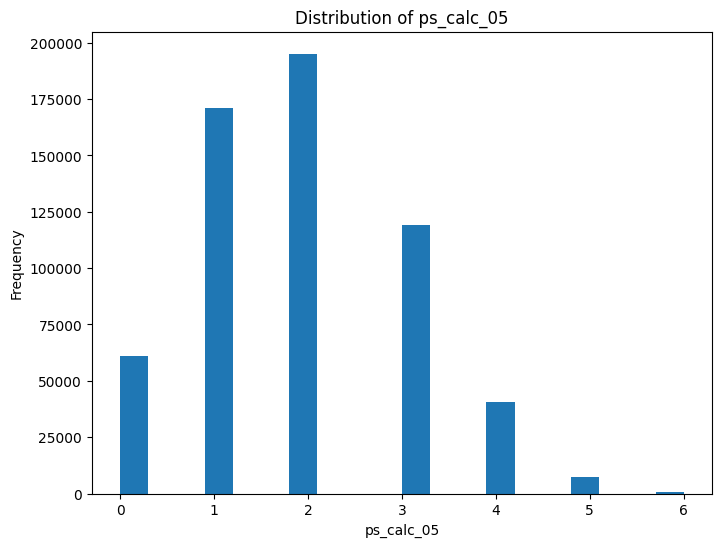

ps_calc_05
2    195160
1    170860
3    119192
0     61226
4     40682
5      7534
6       558
Name: count, dtype: int64


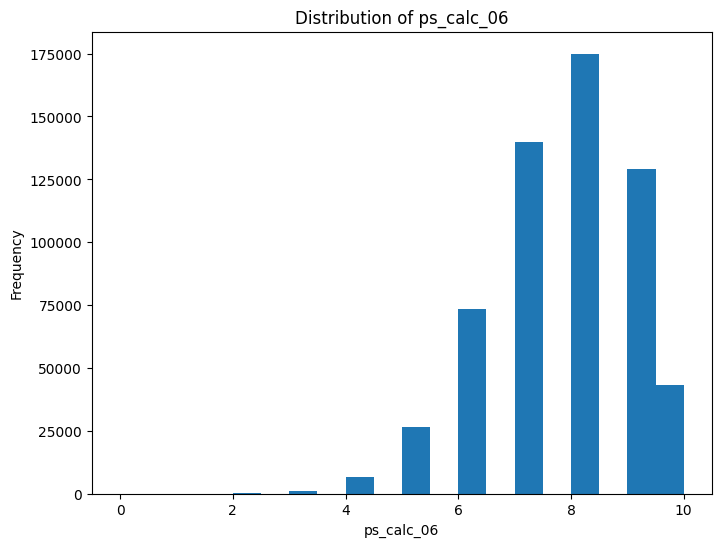

ps_calc_06
8     175015
7     139771
9     129207
6      73478
10     43085
5      26613
4       6705
3       1199
2        132
1          6
0          1
Name: count, dtype: int64


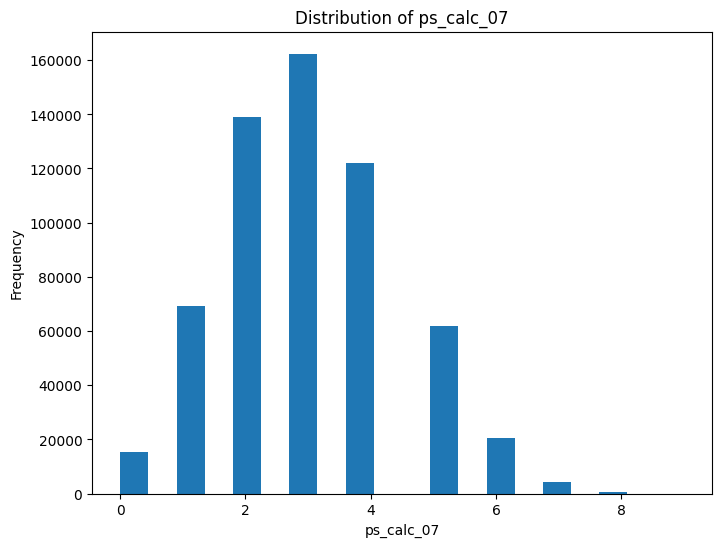

ps_calc_07
3    162414
2    139101
4    122039
1     69309
5     61705
6     20403
0     15290
7      4381
8       547
9        23
Name: count, dtype: int64


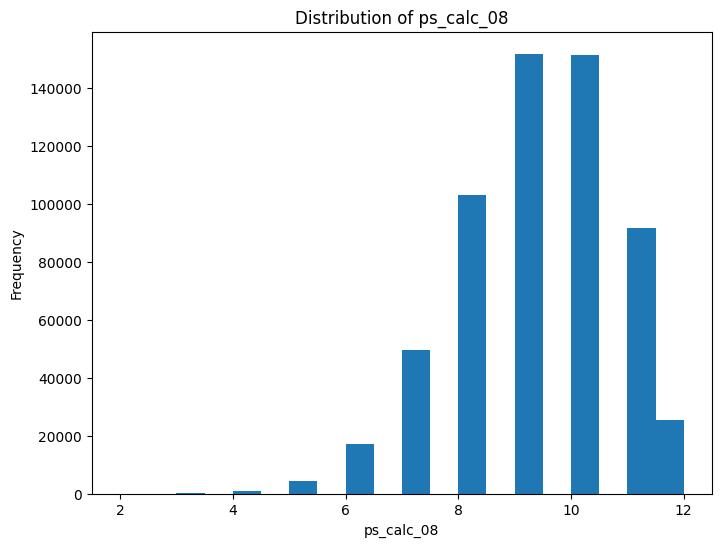

ps_calc_08
9     151746
10    151330
8     102944
11     91639
7      49567
12     25392
6      17183
5       4469
4        842
3         90
2         10
Name: count, dtype: int64


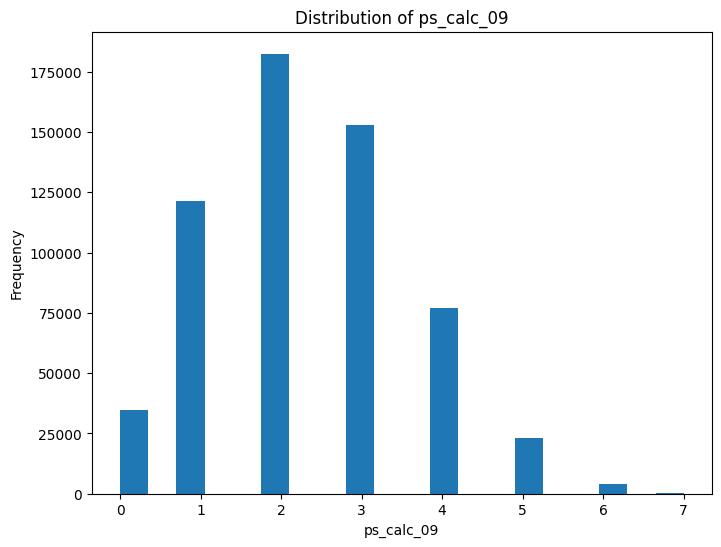

ps_calc_09
2    182519
3    152829
1    121391
4     76973
0     34479
5     22976
6      3782
7       263
Name: count, dtype: int64


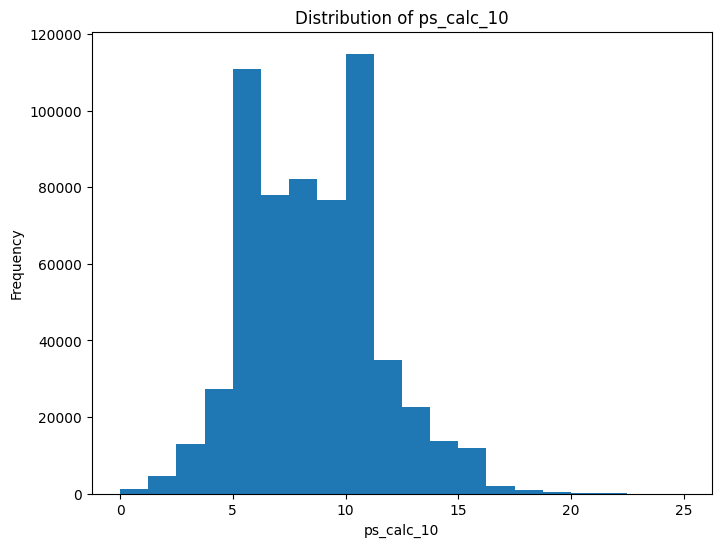

ps_calc_10
8     82043
7     78009
9     76772
10    65307
6     64567
11    49566
5     46181
12    34914
4     27204
13    22709
14    13694
3     12981
15     7701
2      4566
16     4110
17     2041
1      1107
18      922
19      401
20      168
0       139
21       65
22       33
23       10
25        1
24        1
Name: count, dtype: int64


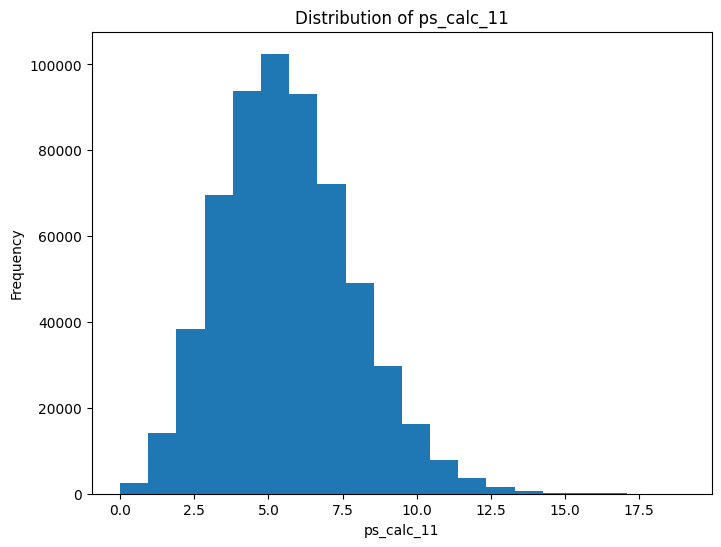

ps_calc_11
5     102512
4      93890
6      93110
7      72148
3      69519
8      49105
2      38364
9      29827
10     16233
1      14035
11      7928
12      3583
0       2461
13      1575
14       631
15       189
16        68
17        22
18        11
19         1
Name: count, dtype: int64


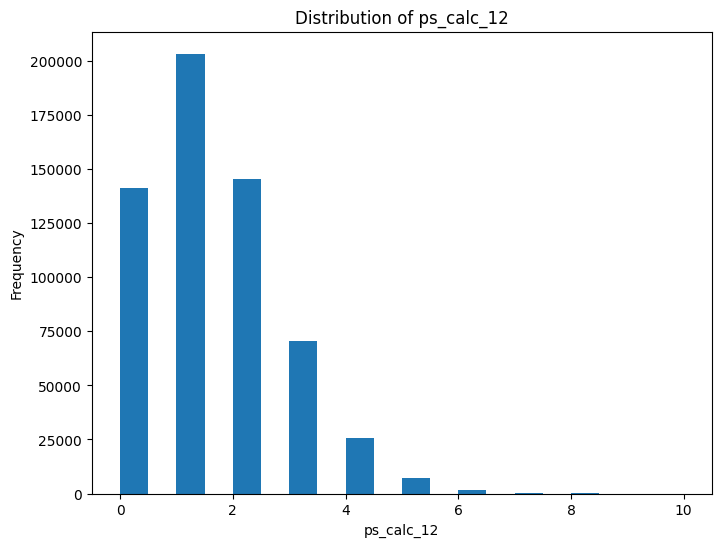

ps_calc_12
1     203280
2     145321
0     141001
3      70351
4      25778
5       7290
6       1724
7        387
8         66
9         11
10         3
Name: count, dtype: int64


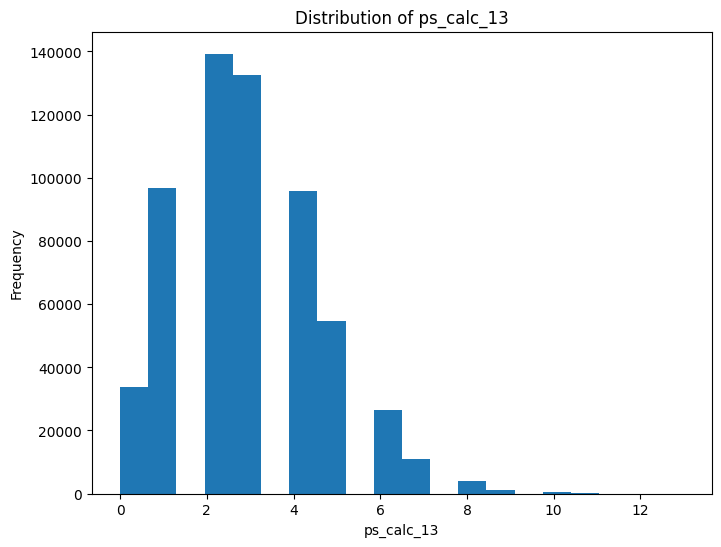

ps_calc_13
2     139334
3     132412
1      96661
4      95753
5      54560
0      33658
6      26326
7      11003
8       3882
9       1160
10       351
11        88
12        20
13         4
Name: count, dtype: int64


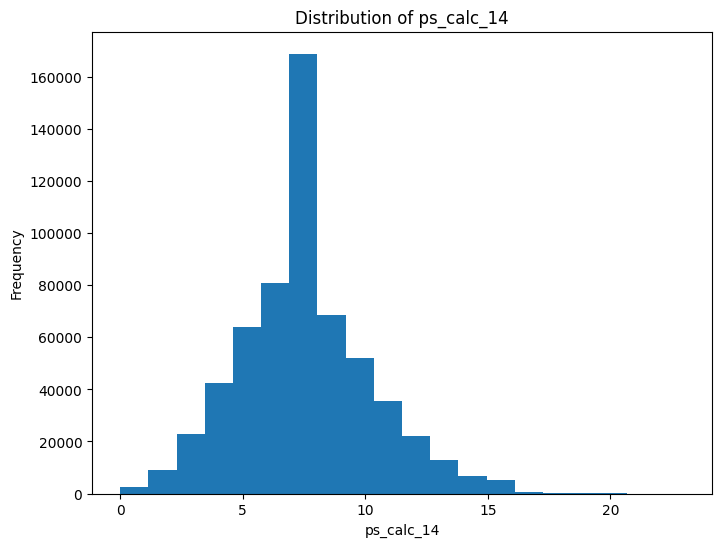

ps_calc_14
7     86673
8     82177
6     80897
9     68487
5     64029
10    52049
4     42596
11    35341
3     22825
12    22227
13    12883
2      8942
14     6934
15     3536
1      2398
16     1666
17      735
0       310
18      305
19      131
20       47
21       18
22        5
23        1
Name: count, dtype: int64


In [56]:
for column in num_cols:
    plt.figure(figsize=(8, 6))  
    train_df[column].hist(bins=20)    
    plt.title(f'Distribution of {column}')  
    plt.xlabel(column)  
    plt.ylabel('Frequency')  
    plt.grid(False)  
    plt.show()
    print(train_df[column].value_counts())

In [57]:
train_df[num_cols] = train_df[num_cols].apply(pd.to_numeric)
train_df[categorical_cols] = train_df[categorical_cols].astype(str)

In [58]:
num_imputer = SimpleImputer(strategy="mean")
num_scaler = StandardScaler()
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
train_df[num_cols] = num_scaler.fit_transform(train_df[num_cols])
test_df[num_cols]  = num_imputer.transform(test_df[num_cols])
test_df[num_cols] = num_scaler.transform(test_df[num_cols])

In [59]:
cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

In [60]:
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

train_encoded = encoder.fit_transform(train_df[categorical_cols])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

train_final_df = pd.concat([train_df.drop(columns=categorical_cols), train_encoded_df], axis=1)


test_encoded = encoder.transform(test_df[categorical_cols])

test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

test_final_df = pd.concat([test_df.drop(columns=categorical_cols), test_encoded_df], axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [61]:
train_final_df.sample(15)

,id,target,ps_ind_01,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99
274357,685674,0,-0.453868,-0.156790,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63801,159719,0,0.554304,1.324746,1.0,0.0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
486186,1214992,0,0.554304,0.583978,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223777,559051,0,-0.453868,-0.527174,1.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247511,618181,0,0.050218,1.324746,1.0,0.0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388107,969760,0,-0.957955,-0.897559,1.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22309,55775,0,-0.957955,-1.267943,1.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460996,1152175,0,0.050218,0.583978,1.0,2.0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
406947,1017141,0,-0.957955,0.954362,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
528337,1320266,0,0.554304,0.954362,0.0,0.0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
train_final_df["target"].value_counts()

target
0    573518
1     21694
Name: count, dtype: int64

In [63]:
y = train_final_df.iloc[:,1].copy()
X = train_final_df.iloc[:,2:].copy()

In [64]:
X

,ps_ind_01,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,...,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99
0,0.050218,0.213594,1.0,0.0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.453868,0.954362,0.0,0.0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.562477,1.695130,1.0,0.0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.957955,-0.897559,0.0,0.0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.957955,-1.638327,1.0,0.0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,0.554304,2.065514,0.0,0.0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595208,1.562477,-0.527174,0.0,0.0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595209,-0.453868,2.065514,0.0,0.0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595210,1.562477,-0.527174,1.0,0.0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#catboost_model=CatBoostRegressor(verbose=0)

In [66]:
def gini(actual, pred):
    assert len(actual) == len(pred)
    all_data = np.c_[actual, pred, np.arange(len(actual))]
    all_data = all_data[np.lexsort((all_data[:, 2], -1 * all_data[:, 1]))]
    total_losses = all_data[:, 0].sum()
    gini_sum = all_data[:, 0].cumsum().sum() / total_losses

    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)

def normalized_gini(y_true, y_pred):
    return gini(y_true, y_pred) / gini(y_true, y_true)

gini_scorer = make_scorer(normalized_gini, greater_is_better=True, needs_proba=False)

In [67]:
#param_grid = {
   # 'depth': Integer(4, 10),
    #'learning_rate': Real(0.01, 0.3, 'log-uniform'),
   # 'iterations': Integer(100, 400),
   # 'l2_leaf_reg': Real(1e-2, 10, 'log-uniform'),
   # 'bagging_temperature': Real(0.0, 1.0)
#}

In [68]:
#opt = BayesSearchCV(
    #estimator=catboost_model,
    #search_spaces=param_grid,
    #n_iter=32,  
    #scoring=gini_scorer, 
    #cv=3,  
    #n_jobs=-1,
    #random_state=42
#)

In [69]:
#opt.fit(X,y)
#print("Best parameters found: ", opt.best_params_)
#print("Best cross-validation score: ", opt.best_score_)
#Best parameters found:  OrderedDict([('bagging_temperature', 0.9554779863099283), ('depth', 8), ('iterations', 361), ('l2_leaf_reg', 0.17679226616446445), ('learning_rate', 0.036549283154481964)])
#Best cross-validation score:  0.27930521175500556

In [70]:
catboost_model = CatBoostRegressor(bagging_temperature=0.9554779863099283, depth=8,iterations= 361, l2_leaf_reg=0.17679226616446445, learning_rate= 0.036549283154481964, verbose=0, random_state=42)

In [71]:
catboost_model.fit(X,y)

In [72]:
test_ids = test_final_df["id"]

In [79]:
X_test = test_final_df.iloc[:,1:].copy()

In [80]:
predictions=catboost_model.predict(X_test)

In [81]:
output = pd.DataFrame({'id': test_ids, 'target': predictions})
output.to_csv('submission.csv', index=False)

In [82]:
output

,id,target
0,0,0.030663
1,1,0.030572
2,2,0.037254
3,3,0.018935
4,4,0.036946
...,...,...
892811,1488022,0.103538
892812,1488023,0.044400
892813,1488024,0.033570
892814,1488025,0.023782
